In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from gaia_spec import *

In [2]:
bps = lsst_filters()
bps.update(stubb_fitlers())

In [3]:
response = gaia_response(restore_file='gaia_response_nonoise.npz')

In [36]:
input_mag = 14
sed = Sed()
# Read in an SED that's solar-like, set to g=16, don't bother adding dust.
sed.read_close_SED(6000., 0., 4.4)
fNorm = sed.calcFluxNorm(input_mag, bps['g'])
sed.multiplyFluxNorm(fNorm)

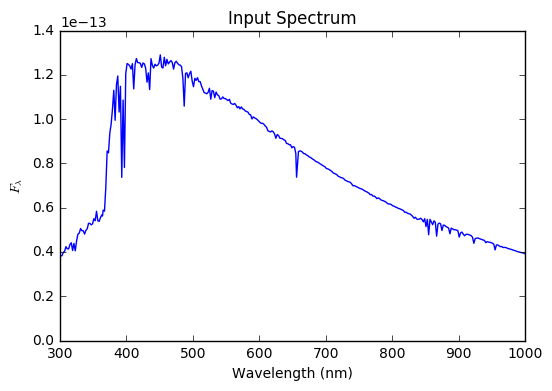

In [29]:
plt.plot(sed.wavelen, sed.flambda)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$F_\lambda$')
plt.xlim([300,1000])
plt.title('Input Spectrum')

In [30]:
workdir = 'plot_work'
gaia_observed = SED2GAIA(sed, workdir=workdir)


In [31]:
observed_sed = ulysses2SED(data=gaia_observed, response=response)
not_nan = ~np.isnan(observed_sed.flambda)
observed_sed.flambda = np.interp(observed_sed.wavelen, observed_sed.wavelen[not_nan],
                                             observed_sed.flambda[not_nan])

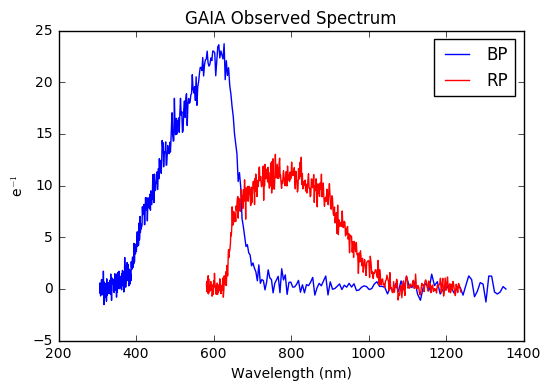

In [32]:
plt.plot(gaia_observed['BP_wave'], gaia_observed['noisySpec'][0]['BPNoisySpec'], 'b', label='BP')
plt.plot(gaia_observed['RP_wave'], gaia_observed['noisySpec'][0]['RPNoisySpec'], 'r', label='RP')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'e$^{-1}$')
plt.title('GAIA Observed Spectrum')

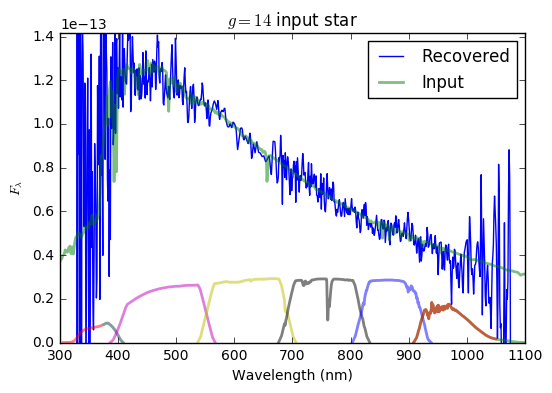

In [40]:
plt.plot(observed_sed.wavelen, observed_sed.flambda, label='Recovered')
plt.plot(sed.wavelen, sed.flambda, label='Input', linewidth=2, alpha=.5)
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$F_\lambda$')
plt.xlim([300,1100])
plt.title(r'$g=%.0f$ input star' % input_mag)
plt.ylim([0,sed.flambda.max()*1.1])
for fn in filters:
    plt.plot(bps[fn].wavelen, bps[fn].sb*sed.flambda.max()*.5, alpha=.5, linewidth=2)
    

In [34]:
filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
print 'filter, input, recovered, diff (mmag)'
for fn in filters:
    inmag = sed.calcMag(bps[fn])
    outmag = observed_sed.calcMag(bps[fn])
    print '%s, %.2f, %.2f, %f' % (fn, inmag, outmag, (inmag-outmag)*1e3)

filter, input, recovered, diff (mmag)
u, 15.03, nan, nan
u_truncated, 14.60, 14.56, 37.627154
g, 14.00, 14.00, -2.299300
r, 13.70, 13.71, -5.599200
i, 13.62, 13.62, -0.885805
z, 13.61, 13.61, -4.985568
y, 13.61, 13.68, -78.501147
y_truncated, 13.60, 13.67, -66.073701
